# Multistyle Style Transfer:

Для того чтобы перенести два стиля одной моделью, необходимо как-то преспособить модель под два $\mathcal L_{style}$

Самым первым решением, приходящим в голову будет добавить в общий лосс третье слагаемое и тогда:

$$	\mathcal L_{total} = \alpha \mathcal L_{content}(input,content) + \beta \mathcal L_{style_1}(input,style_1) + \gamma \mathcal L_{style_2}(input,style_2)$$

In [30]:
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import numpy as np
from tqdm.notebook import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def images_loader(image_names):

    res = []

    for i,name in enumerate(image_names):

        image = Image.open(name)

        if i == 0:
            imsize = np.array(image.size)[::-1]//10

        loader = transforms.Compose([transforms.Resize(imsize),  
                             transforms.CenterCrop(imsize),
                             transforms.ToTensor()])  
        image = loader(image).unsqueeze(0)
        res.append(image)

    return res


names = ["/content/gdrive/My Drive/DeepLearn2020/homework_8/input/1.jpg",
         "/content/gdrive/My Drive/DeepLearn2020/homework_8/style/VanGog.jpeg",
         "/content/gdrive/My Drive/DeepLearn2020/homework_8/style/Pic.jpg"]

content_img, style1_img, style2_img = images_loader(names)

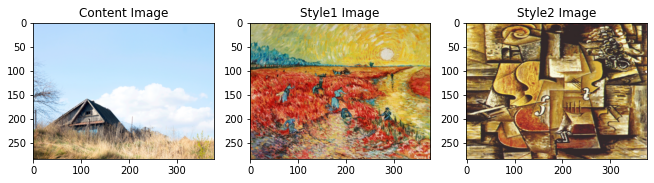

In [48]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

imgs = {'Content Image': content_img,
        'Style1 Image': style1_img,
        'Style2 Image': style2_img
        }

def imshow(dict):

    fig, axes = plt.subplots(1,len(imgs.keys()),figsize=(11,3))

    for i,key in enumerate(dict.keys()):

        image = dict[key].cpu().clone()   
        image = image.squeeze(0)      
        image = unloader(image)
        axes[i].set_title(key)
        axes[i].imshow(image)

    plt.show()

# отрисовка

imshow(imgs)

In [49]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            
            self.target = target.detach()
            self.loss = F.mse_loss(self.target, self.target )

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input


def gram_matrix(input):

        batch_size , h, w, f_map_num = input.size() 
        features = input.view(batch_size * h, w * f_map_num) 
        G = torch.mm(features, features.t())  

        return G.div(batch_size * h * w * f_map_num)


class StyleLoss(nn.Module):

        def __init__(self, target_feature):

            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)

        def forward(self, input):

            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)

            return input


class Normalization(nn.Module):
  
        def __init__(self, mean, std):
            super(Normalization, self).__init__()

            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):

            return (img - self.mean) / self.std

In [50]:
class MST():

  def __init__(self, content_img, style1_img, style2_img):

      super(MST, self).__init__()
      cnn = copy.deepcopy(models.vgg19(pretrained=True).features.to(device).eval())

      mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
      std = torch.tensor([0.229, 0.224, 0.225]).to(device)
      normalization = Normalization(mean, std).to(device)

      self.content_losses = []
      self.style1_losses = []
      self.style2_losses = []

      self.model = nn.Sequential(normalization)

      content_layers = ['conv_4']
      style1_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
      style2_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

      i = 0  
      for layer in cnn.children():
          
          if isinstance(layer, nn.Conv2d):
              i += 1
              name = 'conv_{}'.format(i)
          
          elif isinstance(layer, nn.ReLU):
              name = 'relu_{}'.format(i)
              layer = nn.ReLU(inplace=False)
                
          elif isinstance(layer, nn.MaxPool2d):
              name = 'pool_{}'.format(i)
              
          elif isinstance(layer, nn.BatchNorm2d):
              name = 'bn_{}'.format(i)
          
          else:
              raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
              
          self.model.add_module(name, layer)
          
          if name in content_layers:
              
              target = self.model(content_img).detach()
              content_loss = ContentLoss(target)
              self.model.add_module("content_loss_{}".format(i), content_loss)
              self.content_losses.append(content_loss)
          
          if name in style1_layers:
              
              target_feature = self.model(style1_img).detach()
              style1_loss = StyleLoss(target_feature)
              self.model.add_module("style1_loss_{}".format(i), style1_loss)
              self.style1_losses.append(style1_loss)
          
          if name in style2_layers:
              
              target_feature = self.model(style2_img).detach()
              style2_loss = StyleLoss(target_feature)
              self.model.add_module("style2_loss_{}".format(i), style2_loss)
              self.style2_losses.append(style2_loss)
      
      for i in range(len(self.model) - 1, -1, -1):
        
          if isinstance(self.model[i], ContentLoss) or isinstance(self.model[i], StyleLoss):
              break
      
      self.model = self.model[:(i + 1)]

      print('The MST model has been built')



  def forward(self, x):
      return self.model(x)


  def run(self, input_image, num_epoch=500, style1_weight=100000, 
          style2_weight=100000, content_weight=1):

      print('Start to running...')

      self.input_img = input_image
      optimizer = optim.LBFGS([self.input_img.requires_grad_()])
      cnt = [0]
      tbar = tqdm(total=num_epoch, desc='Epoch')

      while cnt[0] <= num_epoch:

          def closure():

              self.input_img.data.clamp_(0, 1)
              optimizer.zero_grad()
              self.model(self.input_img)

              style1_score = 0
              style2_score = 0
              content_score = 0

              for sl in self.style1_losses:
                  style1_score += sl.loss
                  
              for sl in self.style2_losses:
                  style2_score += sl.loss
              
              for cl in self.content_losses:
                  content_score += cl.loss
                        
              style1_score *= style1_weight
              style2_score *= style2_weight
              content_score *= content_weight

              loss = style1_score + style2_score + content_score
              loss.backward()

              cnt[0] += 1
              tbar.update(1)
              """
              if cnt[0] % 50 == 0:
                  print('Style1 Loss : {:4f}\tStyle2 Loss : {:4f}\tContent Loss: {:4f}\n'.format(
                            style1_score.item(), style2_score.item(), content_score.item()))
              """
              return style1_score + style2_score + content_score


          optimizer.step(closure)
          self.input_img.data.clamp_(0, 1)
      
      print('Finished!')
      return self.input_img

  def show(self):
      
      unloader = transforms.ToPILImage()
      plt.figure()
      image = self.input_img.cpu().clone()   
      image = image.squeeze(0)      
      image = unloader(image)
      plt.title('Output Image')
      plt.imshow(image)
      plt.show()
      
  def save(self, name='res'):

      unloader = transforms.ToPILImage()
      image = self.input_img.cpu().clone()   
      image = image.squeeze(0)      
      image = unloader(image)
      image.save('/content/gdrive/My Drive/DeepLearn2020/homework_8/'+name+'.png')
      print('Result was saved')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


The MST model has been built
Start to running...


Finished!


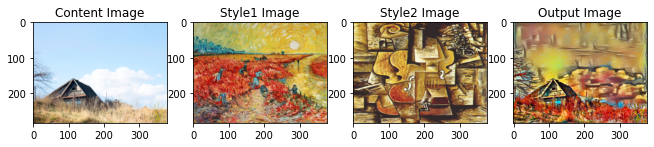

In [53]:
model = MST(content_img, style1_img, style2_img)

input_img = content_img.clone() #torch.rand(content_img.shape)#
output = model.run(input_img)

imgs = {'Content Image': content_img,
        'Style1 Image': style1_img,
        'Style2 Image': style2_img,
        'Output Image': output
        }

imshow(imgs)

plt.ioff()
plt.show()

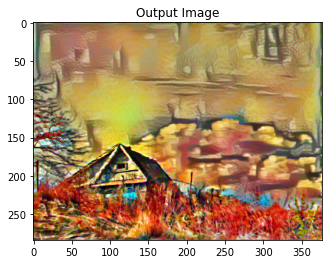

Result was saved


In [54]:
model.show()
model.save(name='house')